#Chemistry in the cloud: leveraging Google Colab for quantum chemistry

Welcome! 

In this workshop I show examples of how [RDKit](https://www.rdkit.org/docs/GettingStartedInPython.html) can be used to automate QM calculations.

The open source QM program [xTB](https://xtb-docs.readthedocs.io/en/latest/contents.html) is used as an example 

We use Google Colab as the programming environment

For similar approaches see [PsiKit](https://github.com/Mishima-syk/psikit) and [ASE](https://wiki.fysik.dtu.dk/ase/).
___

Feel free to make a copy of this notebook and play around with it. Go to File > Save a copy in Drive

Here's a brief [intro video](https://youtu.be/_5Df0wfdH2U) to coding in Colab

Here's a brief [intro video](https://youtu.be/ERvUf_lNopo) to RDKit

#Installation and imports

In [ ]:
%%capture
%%bash
# Install RDKit and xTB. Takes 2-3 minutes
pip install rdkit-pypi
pip install py3Dmol
wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
chmod +x Miniconda3-latest-Linux-x86_64.sh
bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
#conda install -q -y -c conda-forge python=3.7
#conda install -q -y -c conda-forge rdkit=2020.09.2
conda install -q -y -c conda-forge xtb

In [ ]:
# Much faster RDKit install if you don't need xTB
#%%capture
#!pip install kora
#import kora.install.rdkit as rdkit
#!pip install py3Dmol

In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

from rdkit import Chem
from rdkit.Chem import AllChem
from collections import defaultdict
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDistGeom
IPythonConsole.ipython_3d = True

import py3Dmol
import matplotlib.pyplot as plt
import subprocess

#Functions

These functions are also available [here](https://github.com/jensengroup/rdkit_qm_utilities)

##write_xyz

In [ ]:
def write_xyz(mol, file_name='temp.xyz'):
  number_of_atoms = mol.GetNumAtoms()
  symbols = [a.GetSymbol() for a in mol.GetAtoms()] 
  with open(file_name, "w") as file:
    file.write(str(number_of_atoms)+"\n")
    file.write("title\n")
    conf = mol.GetConformers()[0]
    for atom,symbol in enumerate(symbols):
      p = conf.GetAtomPosition(atom)
      line = " ".join((symbol,str(p.x),str(p.y),str(p.z),"\n"))
      file.write(line)

##show_mol

In [ ]:
def show_mol(file_name, animate=False):
  xyz=open(file_name, 'r').read()
  p = py3Dmol.view(width=400,height=400)
  if animate:
    p.addModelsAsFrames(xyz,'xyz')
    p.animate({'loop': "forward",'reps': 5})
    #p.animate({'loop': 'backAndForth'})
  else:
    p.addModel(xyz,'xyz')
  p.setStyle({'stick':{}})
  p.setBackgroundColor('0xeeeeee')
  p.zoomTo()
  p.show()

##get_best_structure

In [ ]:
def get_best_structure(mol,n_confs=10):
  new_mol = Chem.Mol(mol)

  AllChem.EmbedMultipleConfs(mol,numConfs=n_confs,useExpTorsionAnglePrefs=True,useBasicKnowledge=True)
  energies = AllChem.MMFFOptimizeMoleculeConfs(mol,maxIters=2000, nonBondedThresh=100.0)

  energies_list = [e[1] for e in energies]
  min_e_index = energies_list.index(min(energies_list))

  new_mol.AddConformer(mol.GetConformer(min_e_index))

  return new_mol

##shell

In [ ]:
def shell(cmd, shell=False):
  #Written by Jimmy Kromann
  if shell:
    p = subprocess.Popen(cmd, shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
  else:
    cmd = cmd.split()
    p = subprocess.Popen(cmd, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

  output, err = p.communicate()
  return output

##run_xTB

In [ ]:
def run_xTB(mol, command, file_name='temp.xyz', conf_search=False):
  mol = Chem.AddHs(mol)
  if conf_search:
    mol = get_best_structure(mol)
  else:
    rdDistGeom.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol)
  write_xyz(mol)
  command = 'xtb ' + file_name + ' ' + command
  output = shell(command)
  output = str(output).replace('\\n','\n')
  
  return output

##get_energy

In [ ]:
def get_energy(output):
  output = str(output)
  energy = float(output.split('TOTAL ENERGY')[1].split('Eh')[0])

  return energy

##run_rxn

In [ ]:
 def run_rxn(reactant, smarts): 
  rxn = AllChem.ReactionFromSmarts(smarts)
  ps = rxn.RunReactants((reactant,))
  product = ps[0][0]
  Chem.SanitizeMol(product)
  
  return product

##reorder_product

In [ ]:
def reorder_product(product):
  reorder_inverse = [int(atom.GetProp('react_atom_idx')) for atom in product.GetAtoms()]
  reorder = len(reorder_inverse)*[0]

  for i in range(len(reorder_inverse)):
    reorder[reorder_inverse[i]] = i

  product = Chem.RenumberAtoms(product, reorder)

  return product

##label_atoms

In [ ]:
def label_atoms(mol):
  for i,atom in enumerate(mol.GetAtoms()):
    atom.SetAtomMapNum(i+1)
  
  return mol

##plot_PES

In [ ]:
def plot_PES():
  output = shell('grep energy xtbpath.xyz')
  energies = []
  for line in str(output).split('\\n'):
    if 'energy:' in line:
      energies.append(float(line.split('energy:')[1].split('xtb:')[0]))

  plt.plot(energies,'bo')
  plt.ylabel('Relative energy (kcal/mol)')
  plt.xlabel('Interpolation step')

##offset

In [ ]:
def offset(mol, offset=5):
  smiles = Chem.MolToSmiles(mol, allHsExplicit=True)
  smilesA = smiles.split('.')[0]
  molA_idx = mol.GetSubstructMatch(Chem.MolFromSmiles(smilesA, sanitize=False))
  conf = mol.GetConformer()
  for i in range(mol.GetNumAtoms()):
    p = conf.GetAtomPosition(i)
    if i in molA_idx:
      conf.SetAtomPosition(i,(p.x,p.y,p.z+offset))

  return mol

#Some basics: geometry optimisation and getting the energy from the output

## Geometry optimisation

[PubChem Sketcher](https://pubchem.ncbi.nlm.nih.gov/edit3/index.html): a GUI for SMILES generation

Getting SMILES from [ChemDraw](https://youtu.be/A_gwCZrYIXY)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

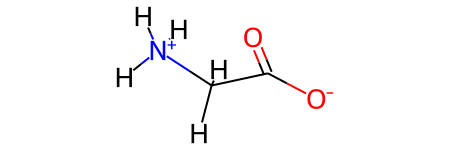

In [ ]:
#mol = Chem.MolFromSmiles('CCCC')
mol = Chem.MolFromSmiles('[NH3+]CC(=O)[O-]')
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)
AllChem.MMFFOptimizeMolecule(mol)
mol

In [ ]:
write_xyz(mol, 'temp.xyz')
!xtb temp.xyz --opt 

      -----------------------------------------------------------      
     |                   =====================                   |     
     |                           x T B                           |     
     |                   =====================                   |     
     |                         S. Grimme                         |     
     |          Mulliken Center for Theoretical Chemistry        |     
     |                    University of Bonn                     |     
      -----------------------------------------------------------      

   * xtb version 6.4.1 (bd6e46d) compiled by 'conda@4901f00b25ba' on 2021-06-10

   xtb is free software: you can redistribute it and/or modify it under
   the terms of the GNU Lesser General Public License as published by
   the Free Software Foundation, either version 3 of the License, or
   (at your option) any later version.
   
   xtb is distributed in the hope that it will be useful,
   but WITHOUT ANY WARRANTY; w

In [ ]:
show_mol('xtbopt.xyz')

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

##Getting a mol object/smiles from an xyz file


In [ ]:
%%capture
!git clone https://github.com/jensengroup/xyz2mol.git
import xyz2mol.xyz2mol as xyz2mol

In [ ]:
atoms, charge, xyz_coordinates = xyz2mol.read_xyz_file('xtbopt.xyz')
mols = xyz2mol.xyz2mol(atoms, xyz_coordinates, charge=charge)

In [ ]:
mol = Chem.RemoveHs(mols[0])
Chem.MolToSmiles(mol)

## Getting the energy from the output

The energy unit (Eh) is Hartree. 1 Hartree = 627.51 kcal/mol = 2625.08 kJ/mol

In [ ]:
output = shell('xtb temp.xyz --opt')
output = str(output)
float(output.split('TOTAL ENERGY')[1].split('Eh')[0])

In [ ]:
mol = Chem.MolFromSmiles('[NH3+]CC(=O)[O-]')
output = run_xTB(mol, '--opt')
energy = get_energy(output)
energy

#Reaction energies: pKa prediction

$HA^+\rightarrow A + H^+$  and $pK_a = \frac{\Delta G^\circ}{RT\ln(10)}$ but $\Delta G^\circ(H^+)=?$

Instead: 

$HA^+ + A_{\mathrm{ref}}\rightarrow A + AH^+_{\mathrm{ref}}$  and $\Delta pK_a = \frac{\Delta G^\circ}{RT\ln(10)}$

where $\Delta G^\circ \approx \Delta E$

[Some pKa values](https://www.cambridgemedchemconsulting.com/resources/tuning_bases.html).  [Paper](https://dx.doi.org/10.1021/acs.jpca.6b10990).

In [ ]:
HAref = Chem.MolFromSmiles('CC[NH3+]')
Aref = Chem.MolFromSmiles('CCN')

Draw.MolsToGridImage([HAref, Aref])

In [ ]:
output = run_xTB(HAref, '--opt --gbsa water --chrg +1', conf_search=True)
HAref_E = get_energy(output)

output = run_xTB(Aref, '--opt --gbsa water', conf_search=True)
Aref_E = get_energy(output)

DeltaE = (Aref_E - HAref_E)*627.51
DeltaE, Aref_E, HAref_E

In [ ]:
amine_smiles = ['FCCN', 'FC(F)CN', 'FC(F)(F)CN']
amines = [Chem.MolFromSmiles(smiles) for smiles in amine_smiles]

rxn = '[N:1]>>[NH3+:1]'
pKas = []
for A in amines:
  HA = run_rxn(A, rxn)
  
  output = run_xTB(HA, '--opt --gbsa water --chrg +1', conf_search=True)
  HA_E = get_energy(output)  

  output = run_xTB(A, '--opt --gbsa water', conf_search=True)
  A_E = get_energy(output)

  Delta_E = (HAref_E + A_E - (Aref_E + HA_E))*627.51
  Delta_pKa = Delta_E/1.36
  pKa = 10.7 + Delta_pKa
  pKas.append(pKa)

pKas


In [ ]:
Draw.MolsToGridImage(amines, legends=[str(round(pKa,1)) for pKa in pKas])

#Barrier estimation

xTB has a quick and dirty [reaction path estimator](https://xtb-docs.readthedocs.io/en/latest/path.html) ([paper1](https://doi.org/10.1021/acs.jctc.9b00143), [paper2](https://doi.org/10.7717/peerj-pchem.15)).

The following energy expression is minimized

$E=E+k_{push} e^{-\alpha \Delta_r^{2}}+k_{pull} e^{-\alpha \Delta_p^{2}}$

where $k_{push}>0$ and $k_{pull}<0$ and $\Delta_r$ and $\Delta_p$ are the RMSDs between the current structure and the reactant and product, respectively.

The reaction path consists of points along the energy minisation path, with the biasing potential removed.

Note that the atom order must be the same in the reactants and products.

## Reaction smarts

In [ ]:
reactant = Chem.MolFromSmiles('C(=O)CCOO')
reactant = Chem.AddHs(reactant)
AllChem.EmbedMolecule(reactant)
AllChem.MMFFOptimizeMolecule(reactant)
reactant = label_atoms(reactant)
reactant

In [ ]:
rxn = '([#8:1]=[#6:2].[#8:3][#1:4])>>[#1:4][#8:1][#6:2][#8:3]'

product = run_rxn(reactant, rxn)
product = reorder_product(product)
AllChem.MMFFOptimizeMolecule(product)
product = label_atoms(product)
product

In [ ]:
write_xyz(reactant, file_name='start.xyz')
write_xyz(product, file_name='end.xyz')

In [ ]:
path_input = '''
$path
   nrun=1
   npoint=25
   anopt=10
   kpush=0.003
   kpull=-0.015
   ppull=0.05
   alp=1.2
$end
'''

with open('path.inp', 'w') as file:
  file.write(path_input)

In [ ]:
!xtb start.xyz --path end.xyz --input path.inp

      -----------------------------------------------------------      
     |                   =====================                   |     
     |                           x T B                           |     
     |                   =====================                   |     
     |                         S. Grimme                         |     
     |          Mulliken Center for Theoretical Chemistry        |     
     |                    University of Bonn                     |     
      -----------------------------------------------------------      

   * xtb version 6.4.1 (bd6e46d) compiled by 'conda@4901f00b25ba' on 2021-06-10

   xtb is free software: you can redistribute it and/or modify it under
   the terms of the GNU Lesser General Public License as published by
   the Free Software Foundation, either version 3 of the License, or
   (at your option) any later version.
   
   xtb is distributed in the hope that it will be useful,
   but WITHOUT ANY WARRANTY; w

In [ ]:
show_mol('xtbpath.xyz', animate=True)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

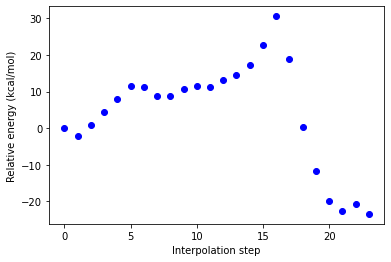

In [ ]:
plot_PES()

##atom_mapper

In [ ]:
%%capture
!git clone https://github.com/jensengroup/atom_mapper.git

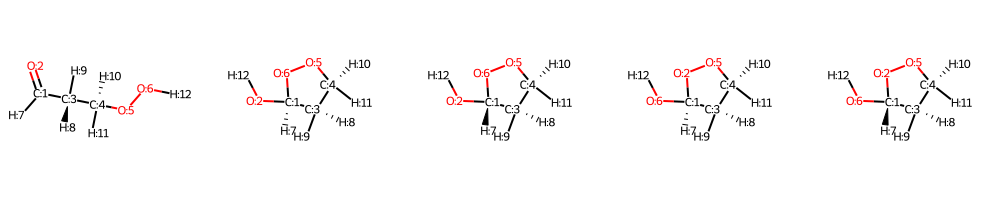

In [ ]:
import atom_mapper as mapper

reactant = Chem.MolFromSmiles('C(=O)CCOO')
reactant = Chem.AddHs(reactant)

product = Chem.MolFromSmiles('C1(O)CCOO1')
product = Chem.AddHs(product)

reactant, products = mapper.atom_mapper(reactant, product)

mols = [reactant]
for prod in products:
  mols += prod

Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200))